In [115]:
import pandas as pd
import numpy as np
import itertools
import random
import time
from tqdm.notebook import tqdm
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
import sys, os


In [116]:
def states():

    # Normal cards
    norm_cards = {"RED":2,"GRE":2,"BLU":2,"YEL":2}
    spec_cards = {"SKI":1,"REV":1,"PL2":1}
    wild_cards = {"PL4":1,"COL":1}

    # Special cards
    norm_cards_play = {"RED#":1,"GRE#":1,"BLU#":1,"YEL#":1}
    spec_cards_play = {"SKI#":1,"REV#":1,"PL2#":1}

    # Combine dictionaries
    states_dict  = {**norm_cards, **spec_cards, **wild_cards, **norm_cards_play, **spec_cards_play}
    states = [["RED","GRE","BLU","YEL"]]

    for val in states_dict.values():
        aux = range(0,val+1)
        states.append(aux)

    # Conduct all combinations
    states = list(itertools.product(*states))
    states_all = list()

    for i in range(len(states)):
        if (states[i][1] >= states[i][10]) and            (states[i][2] >= states[i][11]) and            (states[i][3] >= states[i][12]) and            (states[i][4] >= states[i][13]) and            (states[i][5] >= states[i][14]) and            (states[i][6] >= states[i][15]) and            (states[i][7] >= states[i][16]):
            states_all.append(states[i])

    return states_all


def actions():
    actions_all = ["RED","GRE","BLU","YEL","SKI","REV","PL2","PL4","COL"]    
    return actions_all


def rewards(states, actions):
    R = np.zeros((len(states), len(actions)))
    states_t = [min(sum(states[i][1:10]),1) for i in range(len(states))]

    for i in range(len(states)):
        if states_t[i] == 0:
            R[i] = 1

    R = pd.DataFrame(data = R, 
                     columns = actions, 
                     index = states)

    return R

In [117]:
class ag:
    class QLearningAgent(object):
        
        def agent_init(self, agent_init_info):
            self.states      = states()
            self.actions     = actions()
            self.prev_state  = 0
            self.prev_action = 0
            
            self.epsilon     = agent_init_info["epsilon"]
            self.step_size   = agent_init_info["step_size"]
            self.new_model   = agent_init_info["new_model"]
            self.R           =  rewards(self.states, self.actions)        

            if self.new_model == True:
                self.q = pd.DataFrame(data    = np.zeros((len(self.states), len(self.actions))), 
                                    columns = self.actions, 
                                    index   = self.states)
                
                self.visit = self.q.copy()
            
            else:
                try:
                    self.q            = pd.read_csv("../assets/files/q-learning-q.csv", sep = ";", index_col = "Unnamed: 0")
                    self.q.index      = self.q.index.map(lambda x: eval(x))
                    self.q["IDX"]     = self.q.index
                    self.q            = self.q.set_index("IDX", drop = True)
                    self.q.index.name = None

                    self.visit            = pd.read_csv("../assets/files/q-learning-visits.csv", sep = ";", index_col = "Unnamed: 0")
                    self.visit.index      = self.visit.index.map(lambda x: eval(x))
                    self.visit["IDX"]     = self.visit.index
                    self.visit            = self.visit.set_index("IDX", drop = True)
                    self.visit.index.name = None

                except:
                    print ("Existing model could not be found. New model is being created.")
                    self.q = pd.DataFrame(data    = np.zeros((len(self.states), len(self.actions))), 
                                        columns = self.actions, 
                                        index   = self.states)

                    self.visit = self.q.copy()
                
        
        def step(self, state_dict, actions_dict):

            state = [i for i in state_dict.values()]
            state = tuple(state)
            

            if random.random() < self.epsilon:
                
                actions_possible = [key for key,val in actions_dict.items() if val != 0]         
                action = random.choice(actions_possible)
            
            else:
                actions_possible = [key for key,val in actions_dict.items() if val != 0]
                random.shuffle(actions_possible)
                val_max = 0
                
                for i in actions_possible:
                    val = self.q.loc[[state],i][0]
                    if val >= val_max: 
                        val_max = val
                        action = i
            
            return action
        
        
        def update(self, state_dict, action):
            state = [i for i in state_dict.values()]
            state = tuple(state)
            
            if self.prev_state != 0:
                prev_q = self.q.loc[[self.prev_state], self.prev_action][0]
                this_q = self.q.loc[[state], action][0]
                reward = self.R.loc[[state], action][0]
                
                print ("\n")
                print (f'prev_q: {prev_q}')
                print (f'this_q: {this_q}')
                print (f'prev_state: {self.prev_state}')
                print (f'this_state: {state}')
                print (f'prev_action: {self.prev_action}')
                print (f'this_action: {action}')
                print (f'reward: {reward}')
                
                # Calculate new Q-values
                if reward == 0:
                    self.q.loc[[self.prev_state], self.prev_action] = prev_q + self.step_size * (reward + this_q - prev_q) 
                else:
                    self.q.loc[[self.prev_state], self.prev_action] = prev_q + self.step_size * (reward - prev_q)
                    
                self.visit.loc[[self.prev_state], self.prev_action] += 1
                
            # (2) Save and return action/state
            self.prev_state  = state
            self.prev_action = action


    # 3. Monte Carlo     
            
    class MonteCarloAgent(object):

        def agent_init(self, agent_init_info):
            self.states      =  states()
            self.actions     =  actions()
            self.state_seen  = list()
            self.action_seen = list()
            self.q_seen      = list()
        
            self.epsilon   = agent_init_info["epsilon"]
            self.step_size = agent_init_info["step_size"]
            self.new_model = agent_init_info["new_model"]
            self.R         =  rewards(self.states, self.actions)
            
            if self.new_model == True:
                self.q = pd.DataFrame(data    = np.zeros((len(self.states), len(self.actions))), 
                                    columns = self.actions, 
                                    index   = self.states)
                
                self.visit = self.q.copy()
            
            else:
                try:
                    self.q            = pd.read_csv("../assets/files/monte-carlo-q.csv", sep = ";", index_col = "Unnamed: 0")
                    self.q.index      = self.q.index.map(lambda x: eval(x))
                    self.q["IDX"]     = self.q.index
                    self.q            = self.q.set_index("IDX", drop = True)
                    self.q.index.name = None

                    self.visit            = pd.read_csv("../assets/files/monte-carlo-visits.csv", sep = ";", index_col = "Unnamed: 0")
                    self.visit.index      = self.visit.index.map(lambda x: eval(x))
                    self.visit["IDX"]     = self.visit.index
                    self.visit            = self.visit.set_index("IDX", drop = True)
                    self.visit.index.name = None
                
                except:
                    print ("Existing model could not be found. New model is being created.")
                    self.q = pd.DataFrame(data    = np.zeros((len(self.states), len(self.actions))), 
                                        columns = self.actions, 
                                        index   = self.states)

                    self.visit = self.q.copy()

        
        def step(self, state_dict, actions_dict):
            state = [i for i in state_dict.values()]
            state = tuple(state)
            
            if random.random() < self.epsilon:
                
                actions_possible = [key for key,val in actions_dict.items() if val != 0]         
                action = random.choice(actions_possible)
            
            else:
                actions_possible = [key for key,val in actions_dict.items() if val != 0]
                random.shuffle(actions_possible)
                val_max = 0
                
                for i in actions_possible:
                    val = self.q.loc[[state],i][0]
                    if val >= val_max: 
                        val_max = val
                        action = i
            
            if ((state),action) not in self.q_seen:
                self.state_seen.append(state)
                self.action_seen.append(action)
            
            self.q_seen.append(((state),action))
            self.visit.loc[[state], action] += 1
            
            return action
        
        
        def update(self, state_dict, action):
            state  = [i for i in state_dict.values()]
            state  = tuple(state)
            reward = self.R.loc[[state], action][0]
            
            for s,a in zip(self.state_seen, self.action_seen): 
                self.q.loc[[s], a] += self.step_size * (reward - self.q.loc[[s], a])
                print (self.q.loc[[s],a])
            
            self.state_seen, self.action_seen, self.q_seen = list(), list(), list()

In [118]:
def block_print():
    sys.__stdout__ = sys.stdout
    sys.stdout = open(os.devnull, "w")
    
def enable_print(): 
    sys.stdout = sys.__stdout__

def bold(string):
    chr_start = "\033[1m"
    chr_end = "\033[0m"
    print (chr_start + string + chr_end)
    
def underline(string):
    chr_start = "\033[4m"
    chr_end = "\033[0m"
    print(chr_start + string + chr_end)

In [119]:
class Card(object):
    def __init__(self, c, v):
        self.color = c
        self.value = v
    
    
    def evaluate_card(self, open_c, open_v):
        if (self.color == open_c) or (self.value == open_v) or (self.value in ["COL","PL4"]):
            return True
    
    
    def show_card(self):
        print (self.color, self.value)
    
    
    def print_card(self):
        return str(self.color) + " " + str(self.value)

In [120]:
class Deck(object):
    
    def __init__(self):
        self.cards = []
        self.cards_disc = []
        self.build()
        self.shuffle()
    
    
    def build(self):
        colors = ["RED","GRE","BLU","YEL"]

        cards_zero   = [Card(c,0) for c in colors]
        cards_normal = [Card(c,v) for c in colors for v in range (1,10)]*2
        cards_action = [Card(c,v) for c in colors for v in ["SKI","REV","PL2"]]*2
        cards_wild   = [Card("WILD",v) for v in ["COL","PL4"]]*4
        
        cards_all = cards_normal + cards_action + cards_zero + cards_wild
        for card in cards_all: self.cards.append(card)
    
    
    def discard(self, card):
        self.cards_disc.append(card)
    
    
    def shuffle(self):
        random.shuffle(self.cards)
   

    def draw_from_deck(self):
        if len(self.cards) == 0:
            self.cards = self.cards_disc
            self.cards_disc = []
            
        return self.cards.pop()
    

    def show_deck(self):
        for c in self.cards:
            c.show_card()
                 
    
    def show_discarded(self):
        for c in self.cards_disc:
            c.show_card()

In [121]:
class Player(object):
    def __init__(self, name):
        self.name      = name
        self.hand      = list()
        self.hand_play = list()
        self.card_play = 0
        
        self.state        = dict()
        self.actions      = dict()
        self.action       = 0
        agent.prev_state  = 0
    
    
    def evaluate_hand(self, card_open):   
        self.hand_play.clear()
        for card in self.hand:
            if card.evaluate_card(card_open.color, card_open.value) == True:
                self.hand_play.append(card)
    
    
    def draw(self, deck, card_open):
        card = deck.draw_from_deck()
        self.hand.append(card)
        self.evaluate_hand(card_open)
        print (f'{self.name} draws {card.print_card()}')
        
        
    def identify_state(self, card_open):
        
        norm_cards = {"RED":2,"GRE":2,"BLU":2,"YEL":2}
        spec_cards = {"SKI":1,"REV":1,"PL2":1}
        wild_cards = {"PL4":1,"COL":1}
    
        self.state = dict()
        self.state["OPEN"] = card_open.color
        if self.state["OPEN"] not in ["RED","GRE","BLU","YEL"]: random.choice(["RED","GRE","BLU","YEL"])
        
        # (1) State properties: normal hand cards
        for key, val in zip(norm_cards.keys(), norm_cards.values()):
                self.state[key] = min([1 if (card.color == key) and (card.value in range(0,10)) else 0 for card in self.hand].count(1),val)
        
        # (2) State properties: special hand cards
        for key, val in zip(spec_cards.keys(), spec_cards.values()):
                self.state[key] = min([1 if (card.value == key) else 0 for card in self.hand].count(1),val)
        
        # (3) State properties: wild hand cards
        for key, val in zip(wild_cards.keys(), wild_cards.values()):
                self.state[key] = min([1 if (card.value == key) else 0 for card in self.hand].count(1),val)
        
        # (4) State properties: normal playable cards
        for key, val in zip(norm_cards.keys(), norm_cards.values()):
                self.state[key+"#"] = min([1 if (card.color == key) and (card.value in range(0,10)) else 0 for card in self.hand_play].count(1),val-1)
        
        # (5) State properties: special playable cards
        for key, val in zip(spec_cards.keys(), spec_cards.values()):
                self.state[key+"#"] = min([1 if card.value == key else 0 for card in self.hand_play].count(1),val)
    
    
    def identify_action(self):       
        norm_cards = {"RED":2,"GRE":2,"BLU":2,"YEL":2}
        spec_cards = {"SKI":1,"REV":1,"PL2":1}
        wild_cards = {"PL4":1,"COL":1}
        
        
        # (1) Action properties: normal playable cards
        for key in norm_cards.keys():
            self.actions[key] = min([1 if (card.color == key) and (card.value in range(0,10)) else 0 for card in self.hand_play].count(1),1)
        
        # (2) Action properties: special playable cards
        for key in spec_cards.keys():
            self.actions[key] = min([1 if card.value == key else 0 for card in self.hand_play].count(1),1)
        
        # (3) Action properties: wild playable cards
        for key in wild_cards.keys():
            self.actions[key] = min([1 if card.value == key else 0 for card in self.hand_play].count(1),1)
    
              
    def play_agent(self, deck, card_open):  
        # Identify state & actions for action selection
        self.identify_state(card_open)
        self.identify_action()

        self.action = agent.step(self.state, self.actions)

        # (1) Playing wild card
        if self.action in ["COL","PL4"]:
            for card in self.hand:            
                if card.value == self.action:
                    break

        # (2) Playing normal card with different color
        elif (self.action in ["RED","GRE","BLU", "YEL"]) and (self.action != card_open.color):
            for card in self.hand:
                if (card.color == self.action) and (card.value == card_open.value):
                    break

        # (3) Playing normal card with same color
        elif (self.action in ["RED","GRE","BLU", "YEL"]) and (self.action == card_open.color):
            for card in self.hand:
                if (card.color == self.action) and (card.value in range(0,10)):
                    break

        # (4) Playing special card with same color
        elif (self.action not in ["RED","GRE","BLU", "YEL"]) and (self.action != card_open.value):
            for card in self.hand:
                if (card.color == card_open.color) and (card.value == self.action):
                    break

        # (5) Playing special card with different color
        else:
            for card in self.hand:
                if card.value == self.action:
                    break

        # Selected card is played
        self.card_play = card
        self.hand.remove(card)
        self.hand_play.pop()
        deck.discard(card)
        print (f'\n{self.name} plays {card.print_card()}')

        if (self.card_play.value in ["COL","PL4"]):
            self.card_play.color = self.choose_color()
                  
        if algorithm == "q-learning":
            agent.update(self.state, self.action)
           

    def play_rand(self, deck):
        random.shuffle(self.hand_play)
        for card in self.hand:
            if card == self.hand_play[-1]:
                self.card_play = card
                self.hand.remove(card)
                self.hand_play.pop()
                deck.discard(card)
                print (f'\n{self.name} plays {card.print_card()}')
                break

        if (self.card_play.color == "WILD") or (self.card_play.value == "PL4"):
            self.card_play.color = self.choose_color()
            
            
    def play_counter(self, deck, card_open, plus_card):
        for card in self.hand:
            if card == plus_card:
                self.card_play = card
                self.hand.remove(card)
                deck.discard(card)
                self.evaluate_hand(card_open)
                print (f'{self.name} counters with {card.print_card()}')
                break

        
    def choose_color(self):
        
        colors = [card.color for card in self.hand if card.color in ["RED","GRE","BLU","YEL"]]
        if len(colors)>0:
            max_color = max(colors, key = colors.count)
        else:
            max_color = random.choice(["RED","GRE","BLU","YEL"])

        print (f'{self.name} chooses {max_color}')
        return max_color
    
    
    def show_hand(self):
        underline (f'\n{self.name}s hand:')
        for card in self.hand:
            card.show_card()
           
        
    def show_hand_play(self, card_open):
        underline (f'\n{self.name}s playable hand:')
        self.evaluate_hand(card_open)
        for card in self.hand_play:
            card.show_card()

In [122]:
class Turn(object):
    
    def __init__(self, deck, player_1, player_2):      
        self.deck = deck
        self.player_1 = player_1
        self.player_2 = player_2
        self.card_open = self.deck.draw_from_deck()
        self.start_up()
    
    
    def start_up(self):
        while self.card_open.value not in range(0,10):
            print (f'Inital open card {self.card_open.print_card()} has to be normal')
            self.card_open = self.deck.draw_from_deck()
        
        print (f'Inital open card is {self.card_open.print_card()}\n') 
        
        for i in range (7):
            self.player_1.draw(self.deck, self.card_open)
            self.player_2.draw(self.deck, self.card_open)
            
    
    def action(self, player, opponent):
        player_act = player
        player_pas = opponent
        player_act.evaluate_hand(self.card_open)

        self.count = 0
        
        # (1) When player can play a card directly
        if len(player_act.hand_play) > 0:
            
            if player_act == self.player_1:
                player_act.play_agent(self.deck, self.card_open)
            else:
                player_act.play_rand(self.deck)
                
            self.card_open = player_act.card_play
            player_act.evaluate_hand(self.card_open)

        # (2) When player has to draw a card
        else:
            print (f'{player_act.name} has no playable card')
            player_act.draw(self.deck, self.card_open)
            
            # (2a) When player draw a card that is finally playable
            if len(player_act.hand_play) > 0:
                
                if player_act == self.player_1:
                    player_act.play_agent(self.deck, self.card_open)
                else:
                    player_act.play_rand(self.deck)
                
                self.card_open = player_act.card_play
                player_act.evaluate_hand(self.card_open)
            
            # (2b) When player has not drawn a playable card, do nothing
            else:
                player_act.card_play = Card(0,0)
        
        if check_win(player_act) == True: return
        if check_win(player_pas) == True: return
        
        if player_act.card_play.value == "PL4":
            self.action_plus(player   = player_act, 
                             opponent = player_pas, 
                             penalty  = 4)
        
        if player_act.card_play.value == "PL2":
            self.action_plus(player   = player_act, 
                             opponent = player_pas, 
                             penalty  = 2)
        
        
    def action_plus(self, player, opponent, penalty):
        player_act = player
        player_pas = opponent
        hit, self.count = True, 1

        while hit == True:
            hit = False
            for card in player_pas.hand:
                if card.value == "PL"+str(penalty):
                    player_pas.play_counter(self.deck, self.card_open, plus_card = card)
                    hit = True
                    self.count += 1
                    break
                    
            if check_win(player_pas) == True: return 

            if hit == True:
                hit = False
                for card in player_act.hand:
                    if card.value == "PL"+str(penalty):
                        player_act.play_counter(self.deck, self.card_open, plus_card = card) 
                        hit = True
                        self.count += 1
                        break
                        
            if check_win(player_act) == True: return
        
        
        if self.count%2 == 0:
            print (f'\n{player_act.name} has to draw {self.count*penalty} cards')
            for i in range (self.count*penalty): player_act.draw(self.deck, self.card_open)

        else:
            print (f'\n{player_pas.name} has to draw {self.count*penalty} cards')
            for i in range (self.count*penalty): player_pas.draw(self.deck, self.card_open)

In [123]:
class Game(object):

    
    def __init__(self, player_1_name, player_2_name, starting_name, comment):
        
        if comment == False: block_print()
        
        self.player_1 = Player(player_1_name)
        self.player_2 = Player(player_2_name)
        self.turn = Turn(deck = Deck(), player_1 = self.player_1, player_2 = self.player_2)
        
        self.turn_no = 0
        self.winner = 0

        while self.winner == 0:
            self.turn_no += 1
            card_open = self.turn.card_open
            bold (f'\n---------- TURN {self.turn_no} ----------')
            print (f'\nCurrent open card: {self.turn.card_open.print_card()}')

            if starting_name == self.player_1.name:
                if self.turn_no%2 == 1: player_act, player_pas = self.player_1, self.player_2
                else:                   player_act, player_pas = self.player_2, self.player_1
            else:
                if self.turn_no%2 == 0: player_act, player_pas = self.player_1, self.player_2
                else:                   player_act, player_pas = self.player_2, self.player_1

            player_act.show_hand()
            player_act.show_hand_play(card_open)
            self.turn.action(player = player_act, opponent = player_pas)
            
            if check_win(player_act) == True:
                self.winner = player_act.name
                print (f'{player_act.name} has won!')
                break
                
            if check_win(player_pas) == True:
                self.winner = player_pas.name
                print (f'{player_pas.name} has won!')
                break
                
            if player_act.card_play.value in ["REV", "SKIP"]:
                print (f'{player_act.name} has another turn')
                self.turn_no = self.turn_no-1
                
            if (self.turn.count > 0) and (self.turn.count %2 == 0):
                print (f'Again it is {player_act.name}s turn')
                self.turn_no = self.turn_no-1
        

        self.player_1.identify_state(card_open)
        agent.update(self.player_1.state, self.player_1.action)
                
        if comment == False: enable_print()

In [124]:
def tournament(iterations, algo, comment, agent_info):
    timer_start = time.time()
    
    global agent, algorithm
    algorithm = algo
    
    if algo == "q-learning":
        agent = ag.QLearningAgent()
    else:
        agent = ag.MonteCarloAgent()
    
    
    winners, turns, coverage = list(), list(), list()
    agent.agent_init(agent_info)

    for i in tqdm(range(iterations)):
        time.sleep(0.01)

        if i%2 == 1:
            game = Game(player_1_name = "Vireen", 
                        player_2_name = "Sahitya",
                        starting_name = "Sahitya",
                        comment = comment)
        else:
            game = Game(player_1_name = "Vireen", 
                        player_2_name = "Sahitya",
                        starting_name = "Vireen",
                        comment = comment)

        winners.append(game.winner)
        turns.append(game.turn_no)
        coverage.append((agent.q != 0).values.sum())

    # Timer
    timer_end = time.time()
    timer_dur = timer_end - timer_start
    print (f'Execution lasted {round(timer_dur/60,2)} minutes ({round(iterations/timer_dur,2)} games per second)')
    
    return winners, turns, coverage

def check_win(player):
    if len(player.hand) == 0:
        return True

In [125]:
def bold(string):
    chr_start = "\033[1m"
    chr_end = "\033[0m"
    print (chr_start + string + chr_end)
    
def underline(string):
    chr_start = "\033[4m"
    chr_end = "\033[0m"
    print(chr_start + string + chr_end)

In [126]:
def color_lib(categories):
    c_scale = cm.rainbow(np.linspace(0,1,len(categories)))
    c_dict = {}

    for i,c in zip(categories,c_scale):
        c_dict[i] = c
        
    return c_dict

In [127]:
# Widgets for settings
widg_sim       = widgets.IntText(value = 100, description = "Simulations:")
widg_algo      = widgets.Dropdown(options=["monte-carlo","q-learning"], value="monte-carlo", description="Algorithm:")
widg_new_model = widgets.Dropdown(options=[True,False], value=True, description="New Model:")
widg_comment   = widgets.Dropdown(options=[True,False], value=False, description="Show Game:")

# Widgets for parameters
widg_epsilon = widgets.FloatSlider(value=0.2, min=0, max=1, step=0.01, description="Epsilson:", readout_format=".2f")
widg_step    = widgets.FloatSlider(value=0.2, min=0, max=1, step=0.01, description="Step Size:", readout_format=".2f")

underline ("General Settings:")
display(widg_sim)
display(widg_algo)
display(widg_new_model)
display(widg_comment)

underline ("\nModel Parameters:")
display(widg_epsilon)
display(widg_step)

General Settings:


IntText(value=100, description='Simulations:')

Dropdown(description='Algorithm:', options=('monte-carlo', 'q-learning'), value='monte-carlo')

Dropdown(description='New Model:', options=(True, False), value=True)

Dropdown(description='Show Game:', index=1, options=(True, False), value=False)


Model Parameters:


FloatSlider(value=0.2, description='Epsilson:', max=1.0, step=0.01)

FloatSlider(value=0.2, description='Step Size:', max=1.0, step=0.01)

In [128]:
winners, turns, coverage = list(), list(), list()

In [129]:
agent_info = {"epsilon"  : widg_epsilon.value, 
              "step_size": widg_step.value, 
              "new_model": widg_new_model.value}


run = tournament(iterations = widg_sim.value,
                     algo       = widg_algo.value,
                     comment    = widg_comment.value,
                     agent_info = agent_info)


winners.extend(run[0])
turns.extend(run[1])
coverage.extend(run[2])

  0%|          | 0/10000 [00:00<?, ?it/s]

Execution lasted 15.4 minutes (10.82 games per second)


In [130]:
winners.count("Sahitya")/len(winners)

0.4943

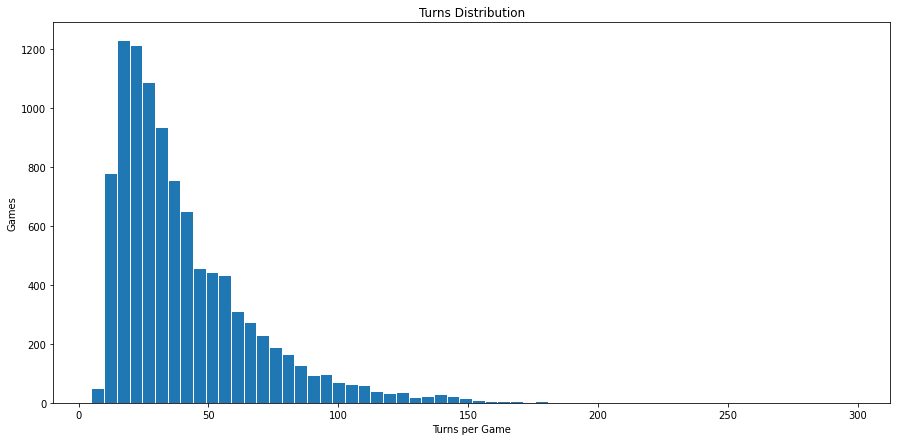

In [131]:
fig = plt.figure(1, figsize=(15,7))

plt.hist(turns, bins =60, edgecolor = "w")
plt.title("Turns Distribution")
plt.xlabel("Turns per Game")
plt.ylabel("Games")

plt.show()

In [132]:
result = pd.concat([pd.Series(winners), pd.Series(turns)], axis = 1)
result = result.rename(columns={0:"Winner",1:"Turns"})

result["Win_rate"] = result["Winner"].apply(lambda x: 1 if x == "Bernhard" else 0)
result["Win_rate"] = result["Win_rate"].cumsum()/(result.index+1)

result.tail()

,Winner,Turns,Win_rate
9995,Vireen,32,0.0
9996,Sahitya,28,0.0
9997,Sahitya,11,0.0
9998,Vireen,23,0.0
9999,Vireen,86,0.0


In [133]:
result["Winner"][-10000:].value_counts()

Vireen     5057
Sahitya    4943
Name: Winner, dtype: int64

In [134]:
q_table = pd.DataFrame(agent.q)
q_table["IDX"] = q_table.index
q_table = q_table.set_index("IDX", drop = True)
q_table.index.name = None

In [135]:
q_table.head()

,RED,GRE,BLU,YEL,SKI,REV,PL2,PL4,COL
"(RED, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
"(RED, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.790285
"(RED, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.000000
"(RED, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
"(RED, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


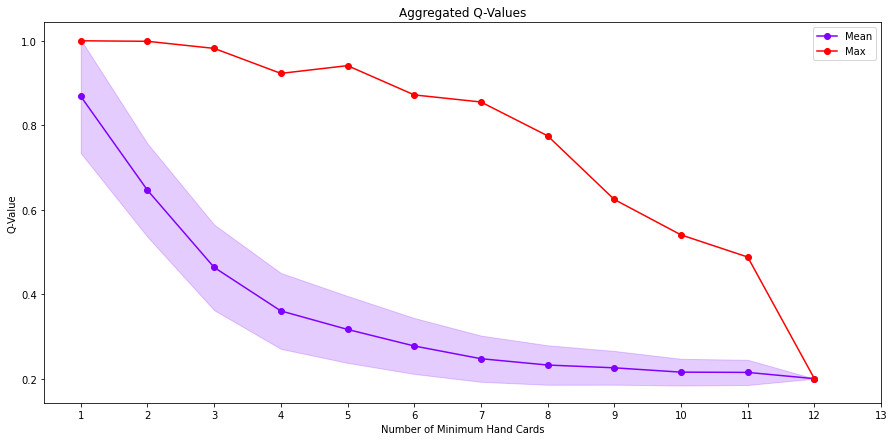

In [136]:
q_curve = q_table.copy()


q_curve["HAND"] = q_curve.index.map(lambda x: sum(x[1:10]))
q_curve["MAX"]  = q_curve[["RED","GRE","BLU","YEL","SKI","REV","PL2","PL4","COL"]].max(axis = 1)
q_curve = q_curve [["HAND","MAX"]].replace(0, np.NaN)


q_mean = pd.Series(q_curve.groupby("HAND").mean()["MAX"])
q_max  = pd.Series(q_curve.groupby("HAND").max()["MAX"])
q_std  = pd.Series(q_curve.groupby("HAND").std()["MAX"])/2


fig = plt.figure(1, figsize=(15,7))
colors = color_lib(["Mean","Max"])

plt.plot(q_mean.index, q_mean, label="Mean", marker = "o", c = colors["Mean"])
plt.plot(q_max.index,  q_max,  label="Max",  marker = "o", c = colors["Max"])
plt.fill_between(q_mean.index, q_mean-q_std, q_mean+q_std, color = colors["Mean"], alpha=0.2)



plt.xticks(q_mean.index)
plt.xlabel("Number of Minimum Hand Cards")
plt.ylabel("Q-Value")
plt.title("Aggregated Q-Values")
plt.legend()
plt.show()

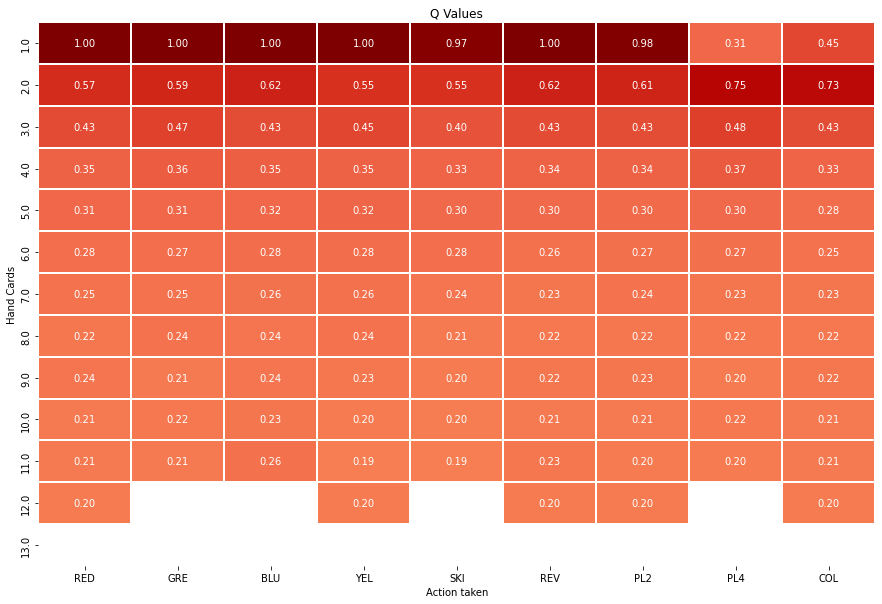

In [137]:
q_pivot = q_table.copy()

q_pivot["HAND"] = q_pivot.index.map(lambda x: sum(x[1:10]))
q_pivot = q_pivot.replace(0, np.NaN)
q_pivot = q_pivot.groupby("HAND").mean()


fig, ax = plt.subplots(1, 1, figsize = (15,10))

sns.heatmap(q_pivot, 
            fmt=".2f", 
            cmap = "OrRd", 
            linewidth = 0.3, 
            annot = True,
            cbar = False,
            center = 0.1)

ax.title.set_text("Q Values")
ax.set(xlabel="Action taken", ylabel="Hand Cards")
plt.show()

In [138]:
q_visited = (q_table != 0).values.sum()
q_possible = 0

for i in range(len(q_table)):
    q_possible += sum(q_table.index[i][8:])
    
print (f'From {q_possible:,} possible combinations {q_visited:,} or {q_visited/q_possible*100:.2f}% have been visited')

From 972,000 possible combinations 19,755 or 2.03% have been visited


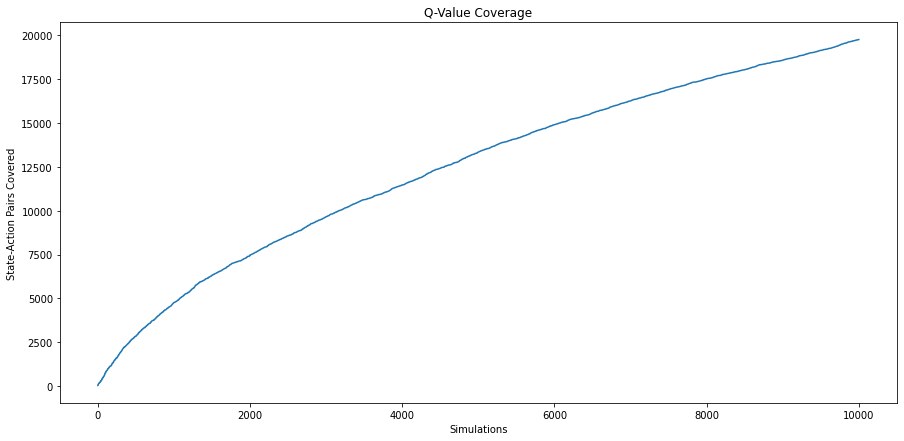

In [139]:
fig = plt.figure(1, figsize=(15,7))

plt.plot(pd.Series(coverage))

plt.xlabel("Simulations")
plt.ylabel("State-Action Pairs Covered")
plt.title("Q-Value Coverage")
plt.show()

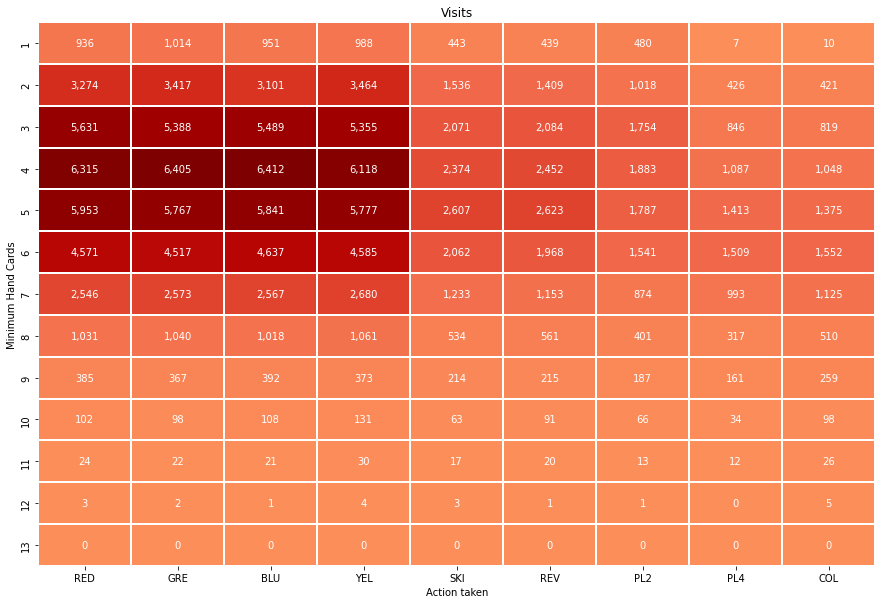

In [140]:
visit = agent.visit.copy()

# Data prep
visit["HAND"] = visit.index.map(lambda x: sum(x[1:10]))
visit = visit.replace(0, np.NaN)
visit = visit.groupby("HAND").sum()
visit.index = visit.index.astype(int)


fig, ax = plt.subplots(1, 1, figsize = (15,10))

sns.heatmap(visit, 
            fmt= ",.0f", 
            cmap = "OrRd", 
            linewidth = 0.3, 
            annot = True,
            cbar = False,
            center = 0.1)

ax.title.set_text("Visits")
ax.set(xlabel="Action taken", ylabel="Minimum Hand Cards")
plt.show()

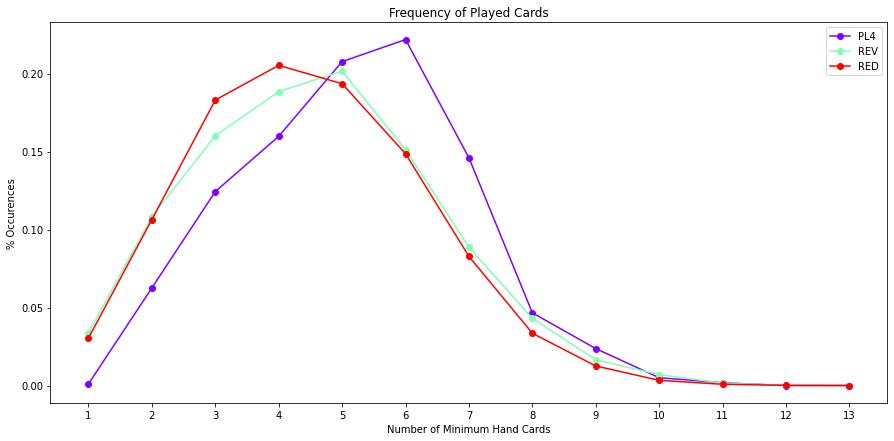

In [141]:
card_type = ["PL4","REV","RED"]
colors = color_lib(card_type)

fig = plt.figure(1, figsize=(15,7))

for i in card_type:
    temp = visit[i]/sum(visit[i])
    plt.plot(temp.index, temp, label=i, marker = "o", c = colors[i])


plt.xticks(temp.index)
plt.xlabel("Number of Minimum Hand Cards")
plt.ylabel("% Occurences")
plt.title("Frequency of Played Cards")
plt.legend()
plt.show()

In [142]:
actions = q_table.columns.to_list()

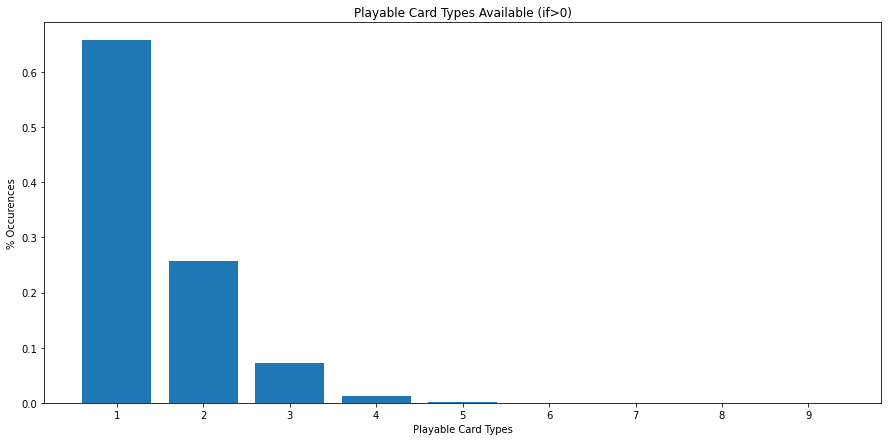

In [144]:
q_check = agent.visit.copy()

# Data prep
q_check["STATE"] = q_check.index
q_check["H_PLAY"]  = q_check["STATE"].apply(lambda x: sum(x[8:]))
q_check = q_check.reset_index(drop = True)

# Plotting
fig = plt.figure(1, figsize=(15,7))

possib = q_check.groupby("H_PLAY").sum()
possib = possib[actions].sum(axis=1)
possib = possib/possib.sum()
possib = possib[1:]

plt.bar(possib.index, possib.values)

# Formatting
plt.xticks(possib.index)
plt.xlabel("Playable Card Types")
plt.ylabel("% Occurences")
plt.title("Playable Card Types Available (if>0)")
plt.show()

In [145]:
q_table.to_csv        (r"D:\Projects and Assignments\Reinforcement\Project\uno-card-game_rl-main"+widg_algo.value+"-q.csv", sep = ";")
agent.visit.to_csv(r"D:\Projects and Assignments\Reinforcement\Project\uno-card-game_rl-main"+widg_algo.value+"-visits.csv", sep = ";")

# Log files
pd.Series(coverage).to_csv(r"D:\Projects and Assignments\Reinforcement\Project\uno-card-game_rl-main"+widg_algo.value+"-coverage.csv", sep = ";")
result.to_csv             (r"D:\Projects and Assignments\Reinforcement\Project\uno-card-game_rl-main"+widg_algo.value+"-result.csv", sep = ";")